In [1]:
import os.path as osp
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

import fish_models

# Data

In [2]:
raycast = fish_models.Raycast(
            n_fish_bins=50,
            n_wall_raycasts=50,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [3]:
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"

dset = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)

Loading data from 197 files.


100%|████████████████████████████████████████| 197/197 [00:06<00:00, 28.48it/s]


Calculating views from 197 files.


100%|████████████████████████████████████████| 197/197 [01:22<00:00,  2.40it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 24639.27it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 28160.24it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 197/197 [00:00<00:00, 1314.15it/s]


Status of IoDataset:
poses	(197, 8, 749, 3):	consisting of x, y, orientation.
actions	(197, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(197, 8, 749, 150):	consisting of 50 fish bins, 50 fish oris and 50 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them


In [4]:
more_than_2_mask = (~np.isnan(dset["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) >= 2
more_than_2_mask.shape, more_than_2_mask.sum()

c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\src\fish_models\datasets\io_dataset.py:456: UserWarning: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
  warn(


((197,), 100)

In [5]:
swarm_poses = dset["poses"][more_than_2_mask]
swarm_actions = dset["actions"][more_than_2_mask]
swarm_views = dset["views"][more_than_2_mask]
swarm_poses.shape, swarm_actions.shape, swarm_views.shape

((100, 8, 749, 3), (100, 8, 749, 2), (100, 8, 749, 150))

In [6]:
np.swapaxes(swarm_views,1,2).shape

(100, 749, 8, 150)

In [7]:
arrrr = np.round(swarm_actions[:,:,:,0].flatten()[~np.isnan(swarm_actions[:,:,:,0].flatten())])
arrrr.min(), arrrr.mean(), arrrr.max()

(8.0, 8.0, 8.0)

In [8]:
swarm_poses[0][(~np.isnan(swarm_poses[0])).any(axis=-1).any(axis=-1)].shape

(2, 749, 3)

In [9]:
n = 3
list2 = []
list1 = np.repeat(np.arange(n), n-1)
for i in range(n):
    list2.append(np.concatenate((np.arange(n)[:i], np.arange(n)[i+1:])))
list2 = np.concatenate(list2)
np.array([list1, list2])

array([[0, 0, 1, 1, 2, 2],
       [1, 2, 0, 2, 0, 1]])

In [10]:
swarm_poses[0,:,0,:]

array([[-13.555  ,  -2.24823,   4.84019],
       [  3.96166,   9.11194,   5.59171],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan]])

In [11]:
data_list = []
for graph_time in swarm_poses:
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, graph2 in zip(graph_time_nonna[:-1], graph_time_nonna[1:]):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(graph2, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
#data_list = [Data(...), ..., Data(...)]
random.seed(5543)
random.shuffle(data_list)

# Once it's shuffled, we slice the data to split
test_len = int(len(data_list) // (1/0.3))
print(test_len)
train_dataset = data_list[test_len:]
test_dataset = data_list[:test_len]
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

22439


In [12]:
data_list = []
for graph_time, graph_action in zip(swarm_poses, swarm_actions):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
#data_list = [Data(...), ..., Data(...)]
random.seed(5543)
random.shuffle(data_list)

# Once it's shuffled, we slice the data to split
test_len = int(len(data_list) // (1/0.3))
print(test_len)
train2_dataset = data_list[test_len:]
test2_dataset = data_list[:test_len]
train2_loader = DataLoader(train2_dataset, batch_size=64)
test2_loader = DataLoader(test2_dataset, batch_size=64)

22469


In [13]:
graph1

array([[ 38.70882, -17.66833,   4.51748],
       [ 36.74626, -18.84466,   4.02631],
       [ 37.71806,   9.5517 ,   2.06669],
       [-21.0441 ,  -4.85445,   2.73919],
       [ 39.23466, -13.84541,   4.81466],
       [ 36.10054, -18.10236,   4.38705],
       [ 33.90295,  -9.24173,   4.76712],
       [ 37.94135, -17.42725,   4.39056]])

In [14]:
graph1[0,:2]

array([ 38.70882, -17.66833])

In [15]:
np.linalg.norm(graph1[1,:2]-graph1[3,:2]) > 40

True

In [16]:
edge_index.shape

torch.Size([2, 56])

In [17]:
print(edge_index[:,(torch.arange(edge_index.shape[1])!=4*7 + (3)) & (torch.arange(edge_index.shape[1])!=3*7 + 4-1)])

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7,
         7, 7, 7, 7, 7, 7],
        [1, 2, 3, 4, 5, 6, 7, 0, 2, 3, 4, 5, 6, 7, 0, 1, 3, 4, 5, 6, 7, 0, 1, 2,
         5, 6, 7, 0, 1, 2, 5, 6, 7, 0, 1, 2, 3, 4, 6, 7, 0, 1, 2, 3, 4, 5, 7, 0,
         1, 2, 3, 4, 5, 6]])


In [18]:
data_list = []
for graph_time, graph_action in zip(swarm_poses, swarm_actions):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    
        
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        
        filt = torch.arange(edge_index.shape[1]) == torch.arange(edge_index.shape[1])
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i == j:
                    continue
                if np.linalg.norm(graph1[i,:2]-graph1[j,:2]) > 40:
                    if i > j:
                        filt = filt & (torch.arange(edge_index.shape[1])!=i*(num_nodes-1) + (j)) & (torch.arange(edge_index.shape[1])!=j*(num_nodes-1) + (i-1))
                    else:
                        filt = filt & (torch.arange(edge_index.shape[1])!=i*(num_nodes-1) + (j-1)) & (torch.arange(edge_index.shape[1])!=j*(num_nodes-1) + (i))
        filt_edge_index = edge_index[:,filt]
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=filt_edge_index, y=y)
        data_list.append(data)
#data_list = [Data(...), ..., Data(...)]
random.seed(5543)
random.shuffle(data_list)

# Once it's shuffled, we slice the data to split
test_len = int(len(data_list) // (1/0.3))
print(test_len)
train3_dataset = data_list[test_len:]
test3_dataset = data_list[:test_len]
train3_loader = DataLoader(train3_dataset, batch_size=64)
test3_loader = DataLoader(test3_dataset, batch_size=64)

22469


In [19]:
pos = 3
data_list[pos].x, data_list[pos].edge_index

(tensor([[ 37.8089,  22.5039,   2.2095],
         [ 28.1483, -20.3009,   4.4975],
         [ 19.1208,  -6.7947,   0.6072],
         [ 36.4703, -25.8552,   5.0419],
         [ 33.1639, -15.4828,   3.7468],
         [ 35.3719, -24.1144,   5.0408]]),
 tensor([[0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5],
         [2, 4, 2, 3, 4, 5, 0, 1, 3, 4, 5, 1, 2, 4, 5, 0, 1, 2, 3, 5, 1, 2, 3, 4]]))

# Model

In [20]:
from torch_geometric.nn import GraphConv

In [21]:
class MarkovSwarmNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.gconv1 = GraphConv(in_channels, hidden_channels)
        self.predictor = GraphConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.gconv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.predictor(x, edge_index)
        return x

# Training

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MarkovSwarmNet(3, 640, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train(epoch):
    model.train()

    if epoch == 16:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001

    if epoch == 40:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001
    
    if epoch == 60:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00001

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        criterion(model(data.x, data.edge_index), data.y).backward()
        optimizer.step()


def test(loader):
    model.eval()
    mse = 0

    for data in loader:
        data = data.to(device)
        mse += criterion(model(data.x, data.edge_index), data.y).item()
    return mse / len(test_dataset)

train_losses = []
test_losses = []
for epoch in range(1, 100):
    train(epoch)
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch: {epoch:02d}, Train: {train_loss:.6f}, Test: {test_loss:.6f}')

Epoch: 01, Train: 6.253114, Test: 2.586304
Epoch: 02, Train: 0.661828, Test: 0.274346
Epoch: 03, Train: 0.031319, Test: 0.012961
Epoch: 04, Train: 0.081373, Test: 0.034508
Epoch: 05, Train: 0.049082, Test: 0.019684
Epoch: 06, Train: 0.028142, Test: 0.011979
Epoch: 07, Train: 0.048426, Test: 0.019776
Epoch: 08, Train: 0.323011, Test: 0.136041
Epoch: 09, Train: 0.035368, Test: 0.014959
Epoch: 10, Train: 0.028022, Test: 0.011727
Epoch: 11, Train: 0.142202, Test: 0.059659
Epoch: 12, Train: 247.696626, Test: 95.630491
Epoch: 13, Train: 0.221781, Test: 0.096017
Epoch: 14, Train: 0.183673, Test: 0.076300
Epoch: 15, Train: 0.169243, Test: 0.071966
Epoch: 16, Train: 0.071364, Test: 0.030561
Epoch: 17, Train: 0.068506, Test: 0.028927
Epoch: 18, Train: 0.067652, Test: 0.028797
Epoch: 19, Train: 0.063057, Test: 0.026906
Epoch: 20, Train: 0.065100, Test: 0.027464
Epoch: 21, Train: 0.055085, Test: 0.023471
Epoch: 22, Train: 0.064185, Test: 0.026246
Epoch: 23, Train: 0.047220, Test: 0.019783
Epoch: 2

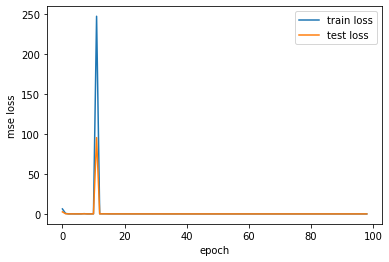

In [23]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.legend()
plt.show()

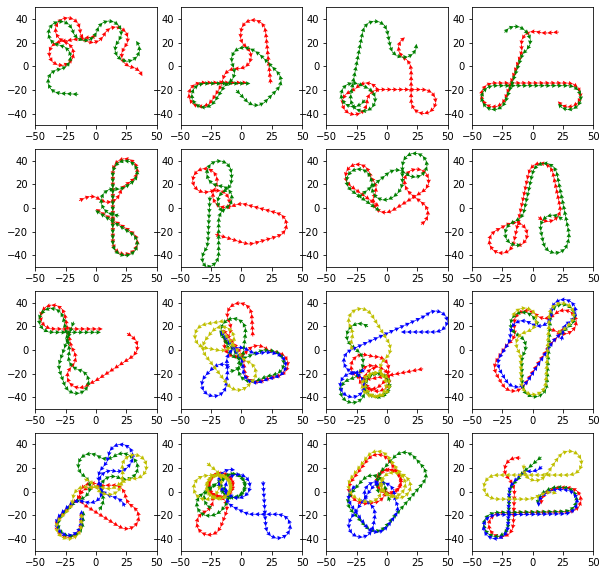

In [24]:
fig, axs = plt.subplots(4,4, figsize=(10,10))
colour_list = ["r", "g", "b", "y"]
counter = 40
for i in range(4):
    for j in range(4):
        for fish_id in range((~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1).sum()):
            #axs[i,j].plot(swarm_poses[counter,fish_id, :, 0], swarm_poses[counter,fish_id, :, 1], label=fish_id)
            a = swarm_poses[counter,fish_id, ::15, 0]
            b = swarm_poses[counter,fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', scale=1, headwidth=5, 
                           color = colour_list[fish_id])
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
        counter +=1
#plt.legend()
plt.show()

In [25]:
def predict_timeseries(start, edge_idx, steps):
    with torch.no_grad():
        model.eval()
        out_list = []
        out_list.append(start.numpy())
        x, edge_index = start.to(device), edge_idx.to(device)
        for step in range(steps):
            pred = model(x, edge_index)
            x = pred
            out_list.append(pred.cpu().numpy())
    out_list = np.array(out_list)
    return out_list

In [26]:
counter = 10
num_nodes = swarm_poses[counter][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)].shape[0]
list2 = []
list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
for i in range(num_nodes):
    list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
list2 = np.concatenate(list2)
start = torch.tensor(swarm_poses[counter,:, 0][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)],
                     dtype=torch.float)
edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
start, edge_index

(tensor([[-19.0294, -10.5283,   1.9159],
         [  3.1025,   8.2205,   5.0143]]),
 tensor([[0, 1],
         [1, 0]]))

In [27]:
predict_timeseries(start, edge_index, 5), predict_timeseries(start, edge_index, 5).shape

(array([[[-19.02938, -10.52834,   1.91585],
         [  3.10249,   8.22051,   5.01432]],
 
        [[-18.60634, -10.19338,   2.27332],
         [  2.96387,   7.99844,   4.60243]],
 
        [[-18.22865,  -9.90123,   2.53895],
         [  2.78403,   7.74972,   4.25836]],
 
        [[-17.88092,  -9.65274,   2.7352 ],
         [  2.57439,   7.48222,   3.97047]],
 
        [[-17.55503,  -9.44006,   2.88067],
         [  2.35075,   7.18937,   3.73165]],
 
        [[-17.25151,  -9.24939,   2.98706],
         [  2.11797,   6.88079,   3.53222]]], dtype=float32),
 (6, 2, 3))

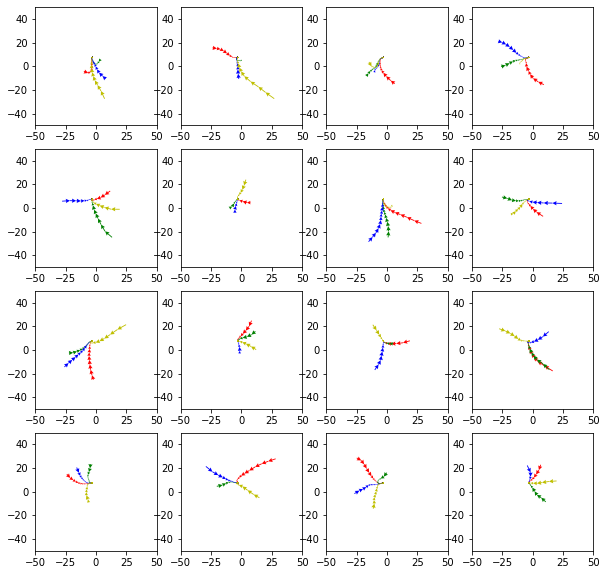

In [28]:
fig, axs = plt.subplots(4,4, figsize=(10,10))
counter = 60
for i in range(4):
    for j in range(4):
        num_nodes = swarm_poses[counter][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)].shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        start = torch.tensor(swarm_poses[counter,:, 0][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)],
                             dtype=torch.float)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        timeseries = predict_timeseries(start, edge_index, swarm_poses.shape[2]-1)
        for fish_id in range((~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1).sum()):
#             axs[i,j].plot(swarm_poses[counter,fish_id, :, 0], swarm_poses[counter,fish_id, :, 1], label=fish_id)
            a = timeseries[::10, fish_id, 0]
            b = timeseries[::10, fish_id, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', scale=1, headwidth=5, 
                           color = colour_list[fish_id])
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
        counter +=1
#plt.legend()
plt.show()

In [ ]:
timeseries_list = []
for counter in range(swarm_poses.shape[0]):
    print(f"counter {counter}/{swarm_poses.shape[0]}", end="\r")
    num_nodes = swarm_poses[counter][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)].shape[0]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for k in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
    list2 = np.concatenate(list2)
    start = torch.tensor(swarm_poses[counter,:, 0][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)],
                         dtype=torch.float)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    timeseries = predict_timeseries(start, edge_index, swarm_poses.shape[2]-1)
    timeseries_list.append(timeseries)
timeseries_list = np.concatenate([arr.reshape(-1, 3) for arr in timeseries_list])

In [ ]:
timeseries_list = np.concatenate([arr.reshape(-1, 3) for arr in timeseries_list])

In [ ]:
timeseries_list.shape

In [ ]:
import seaborn as sns

In [ ]:
sns.kdeplot(x=timeseries_list[:10,0], y=timeseries_list[:10,1], cmap="Blues", shade=True, bw_method=5)
plt.show()

# Training with turn label

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MarkovSwarmNet(3, 640, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train(epoch):
    model.train()

    if epoch == 8:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001

    if epoch == 30:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

    for data in train2_loader:
        data = data.to(device)
        optimizer.zero_grad()
        criterion(model(data.x, data.edge_index), data.y.reshape((-1,1))).backward()
        optimizer.step()


def test(loader):
    model.eval()
    mse = 0

    for data in loader:
        data = data.to(device)
        mse += criterion(model(data.x, data.edge_index), data.y.reshape((-1,1))).item()
    return mse / len(test_dataset)

train2_losses = []
test2_losses = []
for epoch in range(1, 60):
    train(epoch)
    train_loss = test(train2_loader)
    test_loss = test(test2_loader)
    train2_losses.append(train_loss)
    test2_losses.append(test_loss)
    print(f'Epoch: {epoch:02d}, Train: {train_loss:.6f}, Test: {test_loss:.6f}')

Epoch: 01, Train: 6.310673, Test: 2.589726
Epoch: 02, Train: 1.580848, Test: 0.668814
Epoch: 03, Train: 0.053366, Test: 0.022625
Epoch: 04, Train: 0.017841, Test: 0.007699
Epoch: 05, Train: 0.047924, Test: 0.020508
Epoch: 06, Train: 0.019533, Test: 0.008388
Epoch: 07, Train: 0.016037, Test: 0.006934
Epoch: 08, Train: 0.015075, Test: 0.006527
Epoch: 09, Train: 0.015152, Test: 0.006557
Epoch: 10, Train: 0.015252, Test: 0.006614
Epoch: 11, Train: 0.014826, Test: 0.006437
Epoch: 12, Train: 0.015522, Test: 0.006709
Epoch: 13, Train: 0.015549, Test: 0.006752
Epoch: 14, Train: 0.018737, Test: 0.008071
Epoch: 15, Train: 0.018857, Test: 0.008106
Epoch: 16, Train: 0.016881, Test: 0.007296
Epoch: 17, Train: 0.015402, Test: 0.006699
Epoch: 18, Train: 0.018352, Test: 0.007940
Epoch: 19, Train: 0.020851, Test: 0.009044
Epoch: 20, Train: 0.014265, Test: 0.006212
Epoch: 21, Train: 0.013088, Test: 0.005681
Epoch: 22, Train: 0.013174, Test: 0.005738
Epoch: 23, Train: 0.012635, Test: 0.005497
Epoch: 24, 

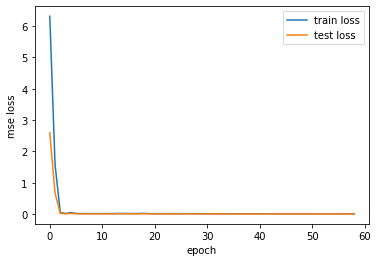

In [104]:
plt.plot(train2_losses, label="train loss")
plt.plot(test2_losses, label="test loss")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.legend()
plt.show()

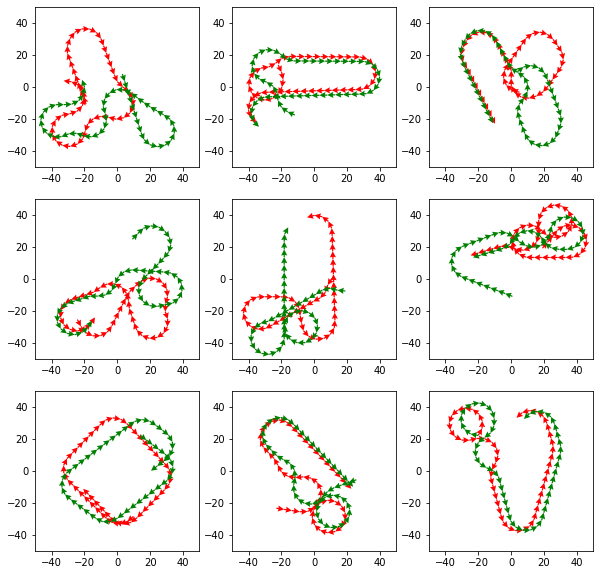

In [108]:
fig, axs = plt.subplots(3,3, figsize=(10,10))
colour_list = ["r", "g", "b", "y"]
counter = 10
for i in range(3):
    for j in range(3):
        for fish_id in range((~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1).sum()):
            #axs[i,j].plot(swarm_poses[counter,fish_id, :, 0], swarm_poses[counter,fish_id, :, 1], label=fish_id)
            a = swarm_poses[counter,fish_id, ::15, 0]
            b = swarm_poses[counter,fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', scale=1, headwidth=5, 
                           color = colour_list[fish_id])
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
        counter +=1
#plt.legend()
plt.show()

In [105]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, regressor):
        #self.raycast = raycast
        self.regressor = regressor

    def choose_action(self, poses_3d, self_id):
        speed = 8
        num_nodes = poses_3d.shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        start = torch.tensor(swarm_poses[counter,:, 0][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)],
                             dtype=torch.float)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        x_input = torch.tensor(poses_3d, dtype=torch.float)
        turn = self.regressor(x_input, edge_index).detach().numpy()[self_id].item()
        return speed, turn

100%|███████████████████████████████████████| 748/748 [00:06<00:00, 124.55it/s]


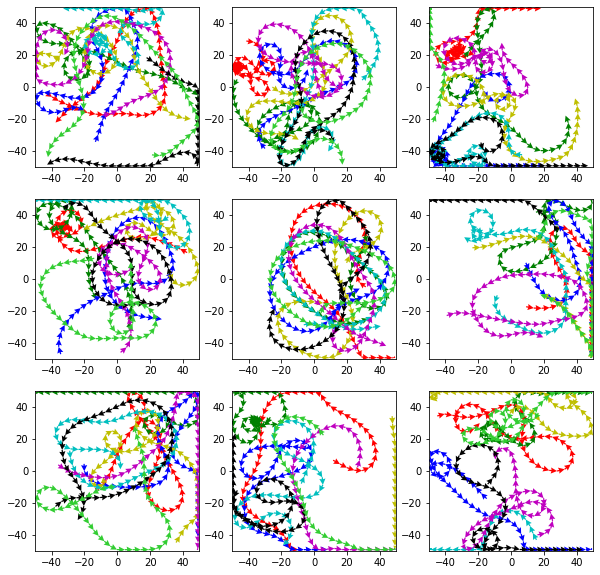

In [109]:
with torch.no_grad():
    model.eval()
    model.to("cpu")
    raymodel = CouzinModel(model)

    generator = fish_models.TrackGeneratorGym(
        [raymodel], world_size=[100,100], frequency=25
)
n = 8
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
        for fish_id in range(n):
            a = track[fish_id, ::15, 0]
            b = track[fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', 
                            scale=1, headwidth=5, color = colour_list[fish_id])
            #axs[i,j].plot(track[fish_id, :, 0], track[fish_id, :, 1], label=fish_id)
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
plt.show()

# Training with turn label and use Zone of attraction for connection

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MarkovSwarmNet(3, 640, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train(epoch):
    model.train()

    if epoch == 8:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001

    if epoch == 40:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001
    
    if epoch == 70:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00001

    for data in train3_loader:
        data = data.to(device)
        optimizer.zero_grad()
        criterion(model(data.x, data.edge_index), data.y.reshape((-1,1))).backward()
        optimizer.step()


def test(loader):
    model.eval()
    mse = 0

    for data in loader:
        data = data.to(device)
        mse += criterion(model(data.x, data.edge_index), data.y.reshape((-1,1))).item()
    return mse / len(test_dataset)

train3_losses = []
test3_losses = []
counter = 0
prev_min = np.inf
for epoch in range(1, 1000):
    train(epoch)
    train_loss = test(train3_loader)
    test_loss = test(test3_loader)
    train3_losses.append(train_loss)
    test3_losses.append(test_loss)
    print(f'Epoch: {epoch:02d}, Train: {train_loss:.6f}, Test: {test_loss:.6f}')
    if counter == 20:
        break
    if test_loss < prev_min:
        prev_min = test_loss
    else:
        counter += 1

Epoch: 01, Train: 13.214607, Test: 5.683725
Epoch: 02, Train: 0.056940, Test: 0.023499
Epoch: 03, Train: 0.031076, Test: 0.013059
Epoch: 04, Train: 0.021290, Test: 0.009108
Epoch: 05, Train: 0.018662, Test: 0.008013
Epoch: 06, Train: 0.016639, Test: 0.007216
Epoch: 07, Train: 0.017396, Test: 0.007463
Epoch: 08, Train: 0.015095, Test: 0.006533
Epoch: 09, Train: 0.014913, Test: 0.006461
Epoch: 10, Train: 0.014910, Test: 0.006464
Epoch: 11, Train: 0.015010, Test: 0.006510
Epoch: 12, Train: 0.014968, Test: 0.006490
Epoch: 13, Train: 0.015503, Test: 0.006700
Epoch: 14, Train: 0.017581, Test: 0.007598
Epoch: 15, Train: 0.017050, Test: 0.007295
Epoch: 16, Train: 0.016534, Test: 0.007129
Epoch: 17, Train: 0.015850, Test: 0.006783
Epoch: 18, Train: 0.013579, Test: 0.005904
Epoch: 19, Train: 0.014609, Test: 0.006351
Epoch: 20, Train: 0.013159, Test: 0.005725
Epoch: 21, Train: 0.013499, Test: 0.005857
Epoch: 22, Train: 0.013823, Test: 0.005993
Epoch: 23, Train: 0.012620, Test: 0.005491
Epoch: 24,

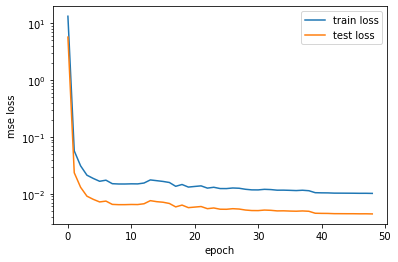

In [79]:
plt.plot(train3_losses, label="train loss")
plt.plot(test3_losses, label="test loss")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.yscale('log')
plt.legend()
plt.show()

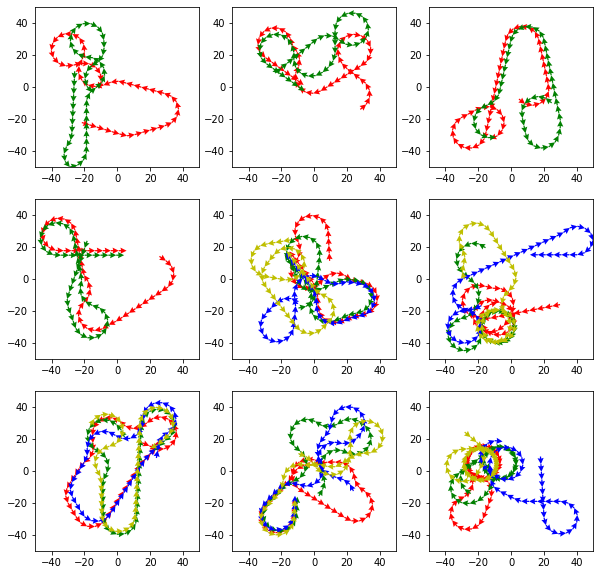

In [98]:
fig, axs = plt.subplots(3,3, figsize=(10,10))
colour_list = ["r", "g", "b", "y"]
counter = 45
for i in range(3):
    for j in range(3):
        for fish_id in range((~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1).sum()):
            #axs[i,j].plot(swarm_poses[counter,fish_id, :, 0], swarm_poses[counter,fish_id, :, 1], label=fish_id)
            a = swarm_poses[counter,fish_id, ::15, 0]
            b = swarm_poses[counter,fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', scale=1, headwidth=5, 
                           color = colour_list[fish_id])
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
        counter +=1
#plt.legend()
plt.show()

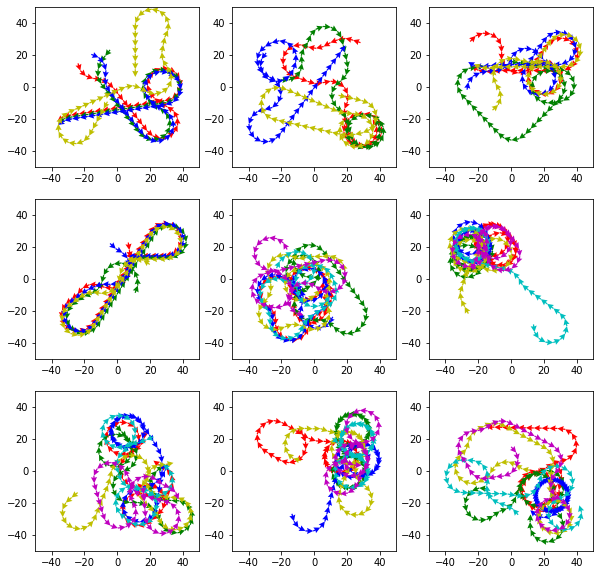

In [96]:
fig, axs = plt.subplots(3,3, figsize=(10,10))
colour_list = ["r", "g", "b", "y", "c", "m", "black", "limegreen"]
counter = 72
for i in range(3):
    for j in range(3):
        for fish_id in range((~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1).sum()):
            #axs[i,j].plot(swarm_poses[counter,fish_id, :, 0], swarm_poses[counter,fish_id, :, 1], label=fish_id)
            a = swarm_poses[counter,fish_id, ::15, 0]
            b = swarm_poses[counter,fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', scale=1, headwidth=5, 
                           color = colour_list[fish_id])
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
        counter +=1
#plt.legend()
plt.show()

In [82]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, regressor):
        #self.raycast = raycast
        self.regressor = regressor

    def choose_action(self, poses_3d, self_id):
        speed = 8
        num_nodes = poses_3d.shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        start = torch.tensor(swarm_poses[counter,:, 0][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)],
                             dtype=torch.float)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        filt = torch.arange(edge_index.shape[1]) == torch.arange(edge_index.shape[1])
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i == j:
                    continue
                if np.linalg.norm(graph1[i,:2]-graph1[j,:2]) > 40:
                    if i > j:
                        filt = filt & (torch.arange(edge_index.shape[1])!=i*(num_nodes-1) + (j)) & (torch.arange(edge_index.shape[1])!=j*(num_nodes-1) + (i-1))
                    else:
                        filt = filt & (torch.arange(edge_index.shape[1])!=i*(num_nodes-1) + (j-1)) & (torch.arange(edge_index.shape[1])!=j*(num_nodes-1) + (i))
        filt_edge_index = edge_index[:,filt]
        x_input = torch.tensor(poses_3d, dtype=torch.float)
        turn = self.regressor(x_input, filt_edge_index).detach().numpy()[self_id].item()
        return speed, turn

100%|████████████████████████████████████████| 748/748 [00:11<00:00, 66.67it/s]


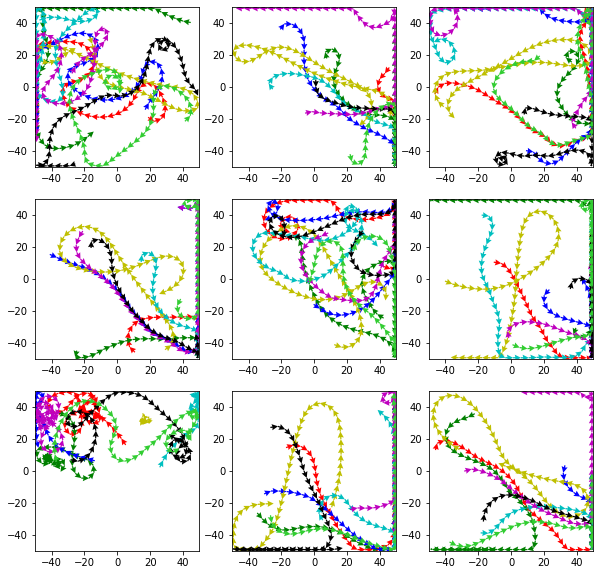

In [102]:
with torch.no_grad():
    model.eval()
    model.to("cpu")
    raymodel = CouzinModel(model)

    generator = fish_models.TrackGeneratorGym(
        [raymodel], world_size=[100,100], frequency=25
)
colour_list = ["r", "g", "b", "y", "c", "m", "black", "limegreen"]
n = 8
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
        for fish_id in range(n):
            a = track[fish_id, ::15, 0]
            b = track[fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', 
                            scale=1, headwidth=5, color = colour_list[fish_id])
            #axs[i,j].plot(track[fish_id, :, 0], track[fish_id, :, 1], label=fish_id)
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
plt.show()